In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/process-data/preprocessed_hotel/dataset_dict.json
/kaggle/input/process-data/preprocessed_hotel/val/state.json
/kaggle/input/process-data/preprocessed_hotel/val/dataset_info.json
/kaggle/input/process-data/preprocessed_hotel/val/data-00000-of-00001.arrow
/kaggle/input/process-data/preprocessed_hotel/test/state.json
/kaggle/input/process-data/preprocessed_hotel/test/dataset_info.json
/kaggle/input/process-data/preprocessed_hotel/test/data-00000-of-00001.arrow
/kaggle/input/process-data/preprocessed_hotel/train/state.json
/kaggle/input/process-data/preprocessed_hotel/train/dataset_info.json
/kaggle/input/process-data/preprocessed_hotel/train/data-00000-of-00001.arrow


In [4]:
!pip install -q emoji
!pip install -q vncorenlp
!pip install -q datasets
!pip install -q accelerate
!pip install -q transformers

In [5]:
!pip install -q tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [6]:
!git clone https://github.com/tranducthai/aspect_base_vietnamese.git
!ls

Cloning into 'aspect_base_vietnamese'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 60 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 672.54 KiB | 4.57 MiB/s, done.
Resolving deltas: 100% (24/24), done.
aspect_base_vietnamese


In [79]:
shutil.rmtree("/kaggle/working/aspect_base_vietnamese")

In [7]:
import sys
sys.path.append('..')


In [8]:
import tensorflow as tf
tf.__version__

2024-11-30 13:50:14.926921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 13:50:14.926987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 13:50:14.928773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.15.0'

In [9]:
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Using GPU:', tf.test.gpu_device_name())
    !nvcc -V
else: raise ValueError('Running on CPU is not recommended.')

Using GPU: /device:GPU:0


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [10]:
TRAIN_PATH = '/kaggle/working/aspect_base_vietnamese/datasets/1-VLSP2018-SA-Hotel-train.csv'
VAL_PATH = '/kaggle/working/aspect_base_vietnamese/datasets/2-VLSP2018-SA-Hotel-dev.csv'
TEST_PATH = '/kaggle/working/aspect_base_vietnamese/datasets/3-VLSP2018-SA-Hotel-test.csv'
PRETRAINED_MODEL = 'vinai/phobert-base'
MODEL_NAME = 'Hotel-v1'
MAX_LENGTH = 256
BATCH_SIZE = 25
EPOCHS = 20

In [12]:
from aspect_base_vietnamese.vlsp_process import VLSP2018Loader
raw_datasets = VLSP2018Loader.load(TRAIN_PATH, VAL_PATH, TEST_PATH)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATUR

In [13]:
from aspect_base_vietnamese.vnprocessor import VietnameseTextPreprocessor

# You should be carefull when using single word replacement for acronyms, because it can cause misinterpretation.
# For example, 'giá': ['price', 'gia'] can replace the word 'gia' in 'gia đình', making it become 'giá đình'.
vn_preprocessor = VietnameseTextPreprocessor(vncorenlp_dir='../processors/VnCoreNLP', extra_teencodes={
    'khách sạn': ['ks'], 'nhà hàng': ['nhahang'], 'nhân viên': ['nv'],
    'cửa hàng': ['store', 'sop', 'shopE', 'shop'],
    'sản phẩm': ['sp', 'product'], 'hàng': ['hàg'],
    'giao hàng': ['ship', 'delivery', 'síp'], 'đặt hàng': ['order'],
    'chuẩn chính hãng': ['authentic', 'aut', 'auth'], 'hạn sử dụng': ['date', 'hsd'],
    'điện thoại': ['dt'],  'facebook': ['fb', 'face'],
    'nhắn tin': ['nt', 'ib'], 'trả lời': ['tl', 'trl', 'rep'],
    'feedback': ['fback', 'fedback'], 'sử dụng': ['sd'], 'xài': ['sài'],
}, max_correction_length=MAX_LENGTH)

2024-11-30 13.50.55 INFO VnCoreNLPServer - Using annotators: wseg
2024-11-30 13:50:55 INFO  WordSegmenter:24 - Loading Word Segmentation model
2024-11-30 13.50.56 INFO VnCoreNLPServer - VnCoreNLPServer is listening on http://127.0.0.1:38237
2024-11-30 13.50.56 INFO log - Logging initialized @784ms to org.eclipse.jetty.util.log.Slf4jLog
2024-11-30 13.50.56 INFO EmbeddedJettyServer - == Spark has ignited ...
2024-11-30 13.50.56 INFO EmbeddedJettyServer - >> Listening on 127.0.0.1:38237
2024-11-30 13.50.56 INFO Server - jetty-9.4.z-SNAPSHOT, build timestamp: 2017-11-21T21:27:37Z, git hash: 82b8fb23f757335bb3329d540ce37a2a2615f0a8
2024-11-30 13.50.56 INFO session - DefaultSessionIdManager workerName=node0
2024-11-30 13.50.56 INFO session - No SessionScavenger set, using defaults
2024-11-30 13.50.56 INFO session - Scavenging every 660000ms
2024-11-30 13.50.56 INFO AbstractConnector - Started ServerConnector@36d7eba1{HTTP/1.1,[http/1.1]}{127.0.0.1:38237}
2024-11-30 13.50.56 INFO Server - Sta

config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

dict.txt:   0%|          | 0.00/360k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

bmd1905/vietnamese-correction-v2 is loaded successfully.


In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
preprocessed_datasets = VLSP2018Loader.preprocess_and_tokenize(raw_datasets, vn_preprocessor, tokenizer, BATCH_SIZE * 2, MAX_LENGTH)
preprocessed_datasets.save_to_disk('../datasets/preprocessed_hotel')

In [16]:
import shutil
shutil.copytree("/kaggle/input/process-data/preprocessed_hotel","/kaggle/working/preprocess_hotel")

'/kaggle/working/preprocess_hotel'

In [17]:
from datasets import load_from_disk
preprocessed_datasets = load_from_disk('/kaggle/working/preprocess_hotel')
preprocessed_datasets = VLSP2018Loader.labels_to_flatten_onehot(preprocessed_datasets)
preprocessed_datasets

[INFO] Transforming "Aspect#Categoy,Polarity" labels to flattened one-hot encoding...


/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/3000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/2000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['FlattenOneHotLabels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
})

In [18]:
ASPECT_CATEGORY_NAMES = raw_datasets['train'].column_names[1:]
print(ASPECT_CATEGORY_NAMES)

['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY', 'FOOD&DRINKS#STYLE&OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT', 'HOTEL#DESIGN&FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS', 'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL', 'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN&FEATURES', 'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES', 'ROOMS#QUALITY', 'ROOM_AMENITIES#CLEANLINESS', 'ROOM_AMENITIES#COMFORT', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOM_AMENITIES#MISCELLANEOUS', 'ROOM_AMENITIES#PRICES', 'ROOM_AMENITIES#QUALITY', 'SERVICE#GENERAL']


In [19]:
steps_per_epoch = len(raw_datasets['train']) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch
total_steps

2400

In [20]:
train_tf_dataset = preprocessed_datasets['train'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_tf_dataset = preprocessed_datasets['val'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)
test_tf_dataset = preprocessed_datasets['test'].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols='FlattenOneHotLabels',
    batch_size=BATCH_SIZE, shuffle=False, num_workers=8
)

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=CosineDecay(
    initial_learning_rate = 1e-4,
    warmup_target = 2e-4,
    warmup_steps = int(total_steps * 0.15), # 15% of total_steps
    decay_steps = int(total_steps * 0.3), # Next 30% of total_steps
    alpha = 0.1, # Minimum lr for decay as a fraction of initial_learning_rate
))

early_stop_callback = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True,
    verbose = 1
)

In [23]:
%%time
from aspect_base_vietnamese.model import VLSP2018Task
model = VLSP2018Task(PRETRAINED_MODEL, ASPECT_CATEGORY_NAMES, optimizer)
history = model.fit(
    train_tf_dataset,
    validation_data = val_tf_dataset,
    callbacks = [early_stop_callback],
    epochs = EPOCHS,
    verbose = 1
).history

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/20


I0000 00:00:1732974836.322542     418 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - 208s 1s/step - loss: 0.1832 - val_loss: 0.1235
Epoch 2/20
120/120 [==============================] - 136s 1s/step - loss: 0.1245 - val_loss: 0.0949
Epoch 3/20
120/120 [==============================] - 135s 1s/step - loss: 0.0918 - val_loss: 0.0818
Epoch 4/20
120/120 [==============================] - 136s 1s/step - loss: 0.0679 - val_loss: 0.0775
Epoch 5/20
120/120 [==============================] - 135s 1s/step - loss: 0.0473 - val_loss: 0.0730
Epoch 6/20
120/120 [==============================] - 134s 1s/step - loss: 0.0282 - val_loss: 0.0703
Epoch 7/20
120/120 [==============================] - 135s 1s/step - loss: 0.0150 - val_loss: 0.0695
Epoch 8/20
120/120 [==============================] - 135s 1s/step - loss: 0.0084 - val_loss: 0.0703
Epoch 9/20
120/120 [==============================] - 135s 1s/step - loss: 0.0061 - val_loss: 0.0716
Epoch 10/20
120/120 [==============================] - 134s 1s/step - loss: 0.0054 - val_loss: 0.0721


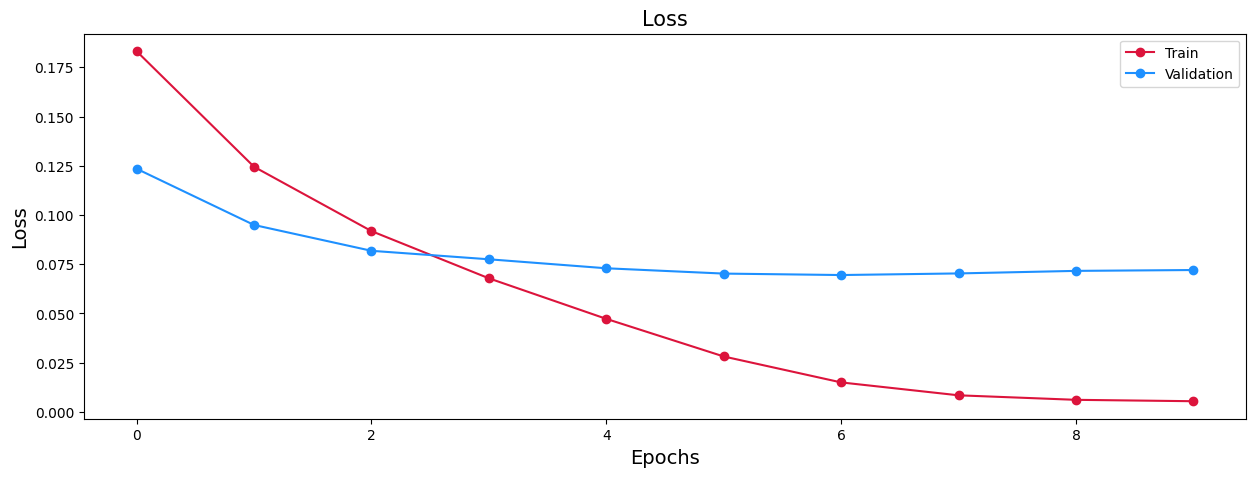

In [25]:
from aspect_base_vietnamese.util import plot_training_history
plot_training_history(history)

In [35]:
model.save_weights(f'./weights/hotel/hotel.weights.h5', save_format='tf')


In [36]:
import dropbox

# Khởi tạo kết nối đến Dropbox
DROPBOX_ACCESS_TOKEN = 'sl.CBsMeD-wViRvXOK3RSvjpdxn09IuGlRbtCm5tljdhlbBYoXeJlL66XUal7LQLNCcGU3gAQ9tLtCrTstGkZuNZ1TAH-9T1VQRlbWS0x7Qlv3s07_RJDwuNNLveGlMSyiGTetg9BMWsJVpnB9YkH87i48'  # Thay YOUR_ACCESS_TOKEN bằng token của bạn
dbx = dropbox.Dropbox(DROPBOX_ACCESS_TOKEN)

# Đường dẫn file trên Dropbox và đường dẫn lưu file trên Kaggle
dropbox_path = f'/aspect_model/weights.h5'
file_weight_path = '/kaggle/working/weights/hotel/hotel.weights.h5' # Đường dẫn lưu file trên Kaggle

# Tải file về từ Dropbox
with open(file_weight_path, 'wb') as f:
    metadata, res = dbx.files_download(path=dropbox_path)
    f.write(res.content)

print(f"File đã được tải về từ Dropbox và lưu tại: {file_weight_path}")

File đã được tải về từ Dropbox và lưu tại: /kaggle/working/weights/hotel/hotel.weights.h5


In [37]:
y_pred = model.acsa_predict(test_tf_dataset, BATCH_SIZE) # On test set
model.evaluate(test_tf_dataset, batch_size=BATCH_SIZE, verbose=1)

24/24 [==============================] - 19s 273ms/step - loss: 0.0833


0.08326923102140427

In [38]:
from aspect_base_vietnamese.util import argmax_label_matrix
y_test = argmax_label_matrix(preprocessed_datasets['test']['FlattenOneHotLabels'])
y_test

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [39]:
y_pred = model.acsa_predict(test_tf_dataset, BATCH_SIZE)

24/24 [==============================] - 19s 267ms/step


In [47]:
from IPython.display import display_html
from sklearn.metrics import classification_report
from aspect_base_vietnamese.vlsp_process import PolarityMapping

In [57]:
class Evaluator:
    def __init__(self, y_test, y_pred, aspect_category_names): 
        aspect_cate_test, aspect_cate_pred = [], []
        aspect_cate_polar_test, aspect_cate_polar_pred = [], []

        for row_test, row_pred in zip(y_test, y_pred):
            for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
                aspect_cate_test.append(aspect_category_names[index] if col_test != 0 else 'None#None')
                aspect_cate_pred.append(aspect_category_names[index] if col_pred != 0 else 'None#None')
                aspect_cate_polar_test.append(aspect_category_names[index] + f',{PolarityMapping.INDEX_TO_POLARITY[col_test]}')
                aspect_cate_polar_pred.append(aspect_category_names[index] + f',{PolarityMapping.INDEX_TO_POLARITY[col_pred]}')

        self.aspect_cate_polar_report = classification_report(aspect_cate_polar_test, aspect_cate_polar_pred, output_dict=True, zero_division=1.0)
        self.aspect_cate_report = classification_report(aspect_cate_test, aspect_cate_pred, output_dict=True, zero_division=1.0)
        self._merge_all_reports()
        self._build_macro_avg_df()
        
    
    def report(self, report_type='all'):
        if report_type.lower() == 'all': self._display_all_reports()
        elif report_type.lower() == 'aspect#category,polarity': return pd.DataFrame(self.aspect_cate_polar_report).T
        elif report_type.lower() == 'aspect#category': return pd.DataFrame(self.aspect_cate_report).T
        elif report_type.lower() == 'macro_avg': return self.macro_avg_df()
        else: raise ValueError('report_type must be in ["all", "aspect#category,polarity", "aspect#category", "polarity", "macro_avg"]')
               
    def _merge_all_reports(self):
        self.merged_report = {}
        for key, metrics in self.aspect_cate_polar_report.items():
            # Check if key in the form of 'aspect#category,polarity' (Check if it's not 'accuracy' or 'macro avg' or 'weighted avg')
            if key in ['accuracy', 'macro avg', 'weighted avg']:
                self.merged_report[key] = {
                    'aspect#category': self.aspect_cate_report[key],
                    'aspect#category,polarity': metrics
                }
            else:
                aspect_cate, polarity = key.split(',')
                if aspect_cate not in self.merged_report:
                    self.merged_report[aspect_cate] = {'aspect#category': self.aspect_cate_report[aspect_cate]}
                self.merged_report[aspect_cate][polarity] = metrics
                
                
    def _build_macro_avg_df(self):
        self.macro_avg_df = pd.DataFrame([{
            'accuracy': f"{report['accuracy']:.3f}", 
            'precision': f"{report['macro avg']['precision']:.3f}",
            'recall': f"{report['macro avg']['recall']:.3f}",
            'f1-score': f"{report['macro avg']['f1-score']:.3f}",
            'support': report['macro avg']['support']
        } for report in [self.aspect_cate_polar_report, self.aspect_cate_report]])
        self.macro_avg_df.index = ['Aspect#Category,Polarity', 'Aspect#Category']
        
    def _display_all_reports(self):
        metric_names = list(self.merged_report.values())[0]['aspect#category']
        html_str = f"""
            <tr>
                <th style="font-weight: bold; text-align: center;" rowspan="2">ACSA Report (w/o "None" polarity)</th>
                <th style="font-weight: bold; text-align: center;" colspan="{len(metric_names)}">Aspect#Category</th>
                <th style="font-weight: bold; text-align: center;" colspan="{len(metric_names)}">Aspect#Category,Polarity</th>
            </tr>
            <tr>
                {''.join([f'<th>{metric_name}</th>' for metric_name in metric_names] * 2)}
            </tr>
        """

        for key, merged_metrics in tqdm(self.merged_report.items()):
            if key in ['accuracy', 'macro avg', 'weighted avg']: continue
            polarities = merged_metrics.keys() - {'aspect#category', 'None'}
            aspect_cate_html = ''.join(
                f'<td rowspan="{len(polarities)}">{value if name == "support" else f"{value:.3f}"}</td>'
                for name, value in self.merged_report[key]['aspect#category'].items()
            )
            for index, polarity in enumerate(polarities):
                aspect_cate_polar_html = ''.join(
                    f'<td>{value if name == "support" else f"{value:.3f}"}</td>'
                    for name, value in self.merged_report[key][polarity].items()
                )
                html_str += f"""
                    <tr>
                        <td>{key},{polarity}</td>
                        {aspect_cate_html if index == 0 else ''}
                        {aspect_cate_polar_html}
                    </tr>
                """

        display_html(f'''
            <div style="display: flex; align-items: flex-start; flex-wrap: nowrap">
                <table style="margin-right: 10px">{html_str}</table> 
                <div style="display: flex; align-items: center; flex-direction: column">              
                    <b>Macro Avg Report</b><br>
                    {self.macro_avg_df.to_html()}
                </div>
            </div>
        ''', raw=True)      

In [58]:
sk_eval = Evaluator(y_test, y_pred, ASPECT_CATEGORY_NAMES)
sk_eval.report(report_type='all')

100%|██████████| 37/37 [00:00<00:00, 40121.32it/s]


ACSA Report (w/o "None" polarity) 
 Aspect#Category 
 Aspect#Category,Polarity 
 
 
 precision recall f1-score support precision recall f1-score support 
 
 
 
 FACILITIES#CLEANLINESS,positive 
 1.000 0.400 0.571 5 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#CLEANLINESS,negative 
 
 1.000 0.667 0.800 3 
 
 
 
 FACILITIES#COMFORT,positive 
 0.667 0.077 0.138 26 
 0.500 0.050 0.091 20 
 
 
 
 FACILITIES#COMFORT,negative 
 
 0.000 0.000 0.000 6 
 
 
 
 FACILITIES#DESIGN&FEATURES,positive 
 0.857 0.462 0.600 65 
 0.750 0.237 0.360 38 
 
 
 
 FACILITIES#DESIGN&FEATURES,negative 
 
 0.652 0.682 0.667 22 
 
 
 
 FACILITIES#DESIGN&FEATURES,neutral 
 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#GENERAL,positive 
 0.688 0.524 0.595 21 
 0.625 0.526 0.571 19 
 
 
 
 FACILITIES#GENERAL,negative 
 
 1.000 0.000 0.000 1 
 
 
 
 FACILITIES#GENERAL,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 FACILITIES#MISCELLANEOUS,positive 
 1.000 0.000 0.000 8 
 1.000 0.000 0.000 3 
 
 
 
 FACILITIES#MISCELLANEOUS,negative 
 
 1.000 0.000 0.000 5 
 
 
 
 FACILITIES#PRICES,positive 
 0.500 0.154 0.235 13 
 0.667 0.250 0.364 8 
 
 
 
 FACILITIES#PRICES,negative 
 
 0.000 0.000 0.000 3 
 
 
 
 FACILITIES#PRICES,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 FACILITIES#QUALITY,positive 
 0.842 0.627 0.719 51 
 0.643 0.375 0.474 24 
 
 
 
 FACILITIES#QUALITY,negative 
 
 0.708 0.680 0.694 25 
 
 
 
 FACILITIES#QUALITY,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,positive 
 1.000 0.000 0.000 3 
 1.000 0.000 0.000 1 
 
 
 
 FOOD&DRINKS#MISCELLANEOUS,negative 
 
 1.000 0.000 0.000 2 
 
 
 
 FOOD&DRINKS#PRICES,positive 
 0.333 0.111 0.167 9 
 0.000 0.000 0.000 6 
 
 
 
 FOOD&DRINKS#PRICES,negative 
 
 0.500 0.333 0.400 3 
 
 
 
 FOOD&DRINKS#QUALITY,positive 
 0.944 0.907 0.925 129 
 0.886 0.969 0.925 96 
 
 
 
 FOOD&DRINKS#QUALITY,negative 
 
 0.833 0.789 0.811 19 
 
 
 
 FOOD&DRINKS#QUALITY,neutral 
 
 1.000 0.071 0.133 14 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,positive 
 0.915 0.871 0.893 124 
 0.800 0.837 0.818 43 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,negative 
 
 0.889 0.853 0.871 75 
 
 
 
 FOOD&DRINKS#STYLE&OPTIONS,neutral 
 
 0.000 0.000 0.000 6 
 
 
 
 HOTEL#CLEANLINESS,positive 
 0.915 0.806 0.857 67 
 0.914 0.898 0.906 59 
 
 
 
 HOTEL#CLEANLINESS,negative 
 
 1.000 0.125 0.222 8 
 
 
 
 HOTEL#COMFORT,positive 
 0.740 0.574 0.647 94 
 0.746 0.662 0.702 80 
 
 
 
 HOTEL#COMFORT,negative 
 
 0.000 0.000 0.000 13 
 
 
 
 HOTEL#COMFORT,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 HOTEL#DESIGN&FEATURES,positive 
 0.840 0.800 0.819 85 
 0.795 0.838 0.816 74 
 
 
 
 HOTEL#DESIGN&FEATURES,negative 
 
 1.000 0.250 0.400 8 
 
 
 
 HOTEL#DESIGN&FEATURES,neutral 
 
 0.000 0.000 0.000 3 
 
 
 
 HOTEL#GENERAL,positive 
 0.902 0.788 0.841 151 
 0.866 0.815 0.840 135 
 
 
 
 HOTEL#GENERAL,negative 
 
 1.000 0.333 0.500 12 
 
 
 
 HOTEL#GENERAL,neutral 
 
 0.000 0.000 0.000 4 
 
 
 
 HOTEL#MISCELLANEOUS,positive 
 0.700 0.103 0.179 68 
 0.000 0.000 0.000 29 
 
 
 
 HOTEL#MISCELLANEOUS,negative 
 
 0.667 0.176 0.279 34 
 
 
 
 HOTEL#MISCELLANEOUS,neutral 
 
 1.000 0.000 0.000 5 
 
 
 
 HOTEL#PRICES,positive 
 0.866 0.817 0.841 71 
 0.831 0.857 0.844 63 
 
 
 
 HOTEL#PRICES,negative 
 
 0.000 0.000 0.000 6 
 
 
 
 HOTEL#PRICES,neutral 
 
 1.000 0.000 0.000 2 
 
 
 
 HOTEL#QUALITY,positive 
 0.750 0.231 0.353 13 
 0.667 0.286 0.400 7 
 
 
 
 HOTEL#QUALITY,negative 
 
 0.000 0.000 0.000 5 
 
 
 
 HOTEL#QUALITY,neutral 
 
 1.000 0.000 0.000 1 
 
 
 
 LOCATION#GENERAL,positive 
 0.977 0.964 0.970 221 
 0.944 0.974 0.959 190 
 
 
 
 LOCATION#GENERAL,negative 
 
 0.619 0.812 0.703 16 
 
 
 
 LOCATION#GENERAL,neutral 
 
 0.000 0.000 0.000 15 
 
 
 
 ROOMS#CLEANLINESS,positive 
 0.930 0.935 0.933 200 
 0.909 0.964 0.936 166 
 
 
 
 ROOMS#CLEANLINESS,negative 
 
 0.840 0.778 0.808 27 
 
 
 
 ROOMS#CLEANLINESS,neutral 
 
 1.000 0.000 0.000 7 
 
 
 
 ROOMS#COMFORT,positive 
 0.745 0.849 0.794 93 
 0.736 0.883 0.803 60 
 
 
 
 ROOMS#COMFORT,negative 
 
 0.647 0.710 0.677 31 
 
 
 
 ROOMS#COMFORT,